# Importing libraries

In [79]:
%matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
import keras
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np

# DataSet information
Our DataSet is composed of lake images, which essentially represents the borders of the lake, and each have a different borders from the other based on a climaic conditions, and they are in the following format: C+classNumber+'.'+className

In [302]:
# directory where images are stored
DIR = "./lake_img"

def dataset_stats():
    
    # This is an array with the letters available.
    # If you add another animal later, you will need to structure its images in the same way
    # and add its letter to this array
    lake_characters = ['V']
    
    # dictionary where we will store the stats
    stats = []
    
    for lake in lake_characters:
        # get a list of subdirectories that start with this character
        directory_list = sorted(glob.glob("{}/[{}]*".format(DIR, lake)))
    
        for sub_directory in directory_list:
            file_names = [file for file in os.listdir(sub_directory)]
            file_count = len(file_names)
            sub_directory_name = os.path.basename(sub_directory)
            stats.append({ "Code": sub_directory_name[:sub_directory_name.find('-')],
                          "Image count": file_count, 
                            "Folder name": os.path.basename(sub_directory),
                          
                            "File names": file_names})
    
    
    df = pd.DataFrame(stats)
    
    return df

In [303]:
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]

,Folder name,Image count
Code,,
V1,V1-high,20
V2,V2-meduim,15
V3,V3-low,16


In [304]:
dataset_stats()

,Code,Image count,Folder name,File names
0,V1,20,V1-high,"[high_11_2014.jpg, high_12_2007.jpg, high_12_2..."
1,V2,15,V2-meduim,"[meduim_12_2004.jpg, meduim_12_2011.jpg, medui..."
2,V3,16,V3-low,"[low_10_2016.jpg, low_11_2016.jpg, low_12_2000..."


# Loading images 
Loaded images are resized to 224 x 224 before storing them in our array since this is the size preferred by VGG19 which we will be using later.

In [305]:
def load_images(codes):
    
    # Define empty arrays where we will store our images and labels
    images = []
    labels = []
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(str(DIR),str(folder_name),str(file))
            
            # Read the image
            image = cv2.imread(file_path)

            # Resize it to 224 x 224
            image = cv2.resize(image, (224,224))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)
            labels.append(code)

    return images, labels

In [306]:
codes = ["V1","V2","V3"]
images, labels = load_images(codes)

# Displaying images

In [85]:
def show_random_images(images, labels, number_of_images_to_show=2):

    for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

2 random images for code V3


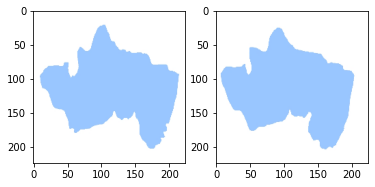

2 random images for code V2


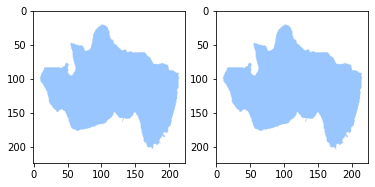

2 random images for code V1


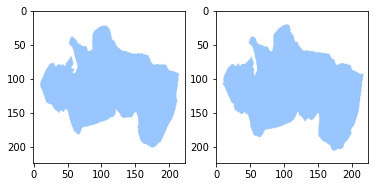

In [86]:
show_random_images(images, labels)

# Normalizing the images

In [87]:
def normalise_images(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

In [88]:
images, labels = normalise_images(images, labels)

# Spliting data 

In [89]:
def shuffle_data(images, labels):

    # Set aside the testing data. We won't touch these until the very end.
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=728)
    
    return X_train, y_train

In [90]:
X_train, y_train = shuffle_data(images, labels)

# Data augmentation

## Random rotation

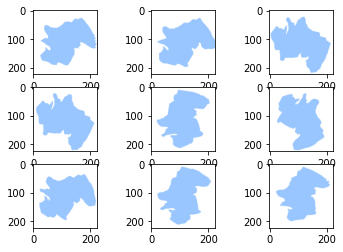

In [91]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K


# convert from int to float
X_train = X_train.astype('float32')

# define data preparation
datagen = ImageDataGenerator(rotation_range=90)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i], cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

## Random shifts

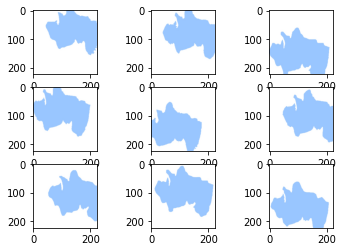

In [92]:
# Random Shifts
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i], cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

## Random flips

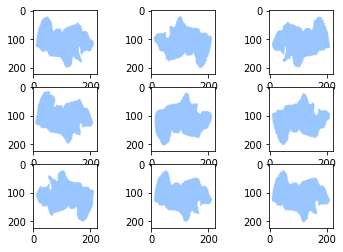

In [93]:
# Random flips
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i], cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

# Load pre-trained covnet models
## VGG16, VG19, ResNet50
We'll now load up the keras models with the imagenet weights. We'll remove the top dense layers, since we won't need to classify things here, and we just want these encoded features from the images.

In [94]:
# Load the models with ImageNet weights

vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

vgg19_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))

resnet50_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))

The covnet models will give us 3D vectors that represent the image. We need to flatten these for the clustering algorithms to start working with them.

In [95]:
def covnet_transform(covnet_model, raw_images):

    # Pass our training data through the network
    pred = covnet_model.predict(raw_images)

    # Flatten the array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat

In [96]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, X_train)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, X_train)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

2/2 [==============================] - 4s 1s/step
VGG16 flattened output has 25088 features
2/2 [==============================] - 5s 1s/step
VGG19 flattened output has 25088 features
2/2 [==============================] - 3s 749ms/step
ResNet50 flattened output has 100352 features


# PCA
We will look to PCA for dimensionality reduction, so that our clustering algorithms can cope.

In [97]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p
    

In [98]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)

In [99]:
# Function to plot the cumulative explained variance of PCA components
# This will help us decide how many components we should reduce our features to
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

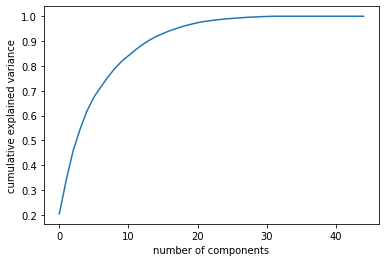

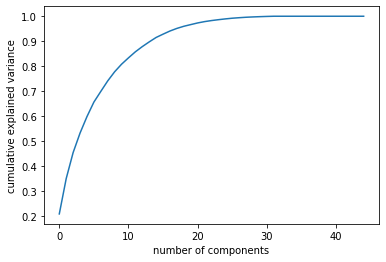

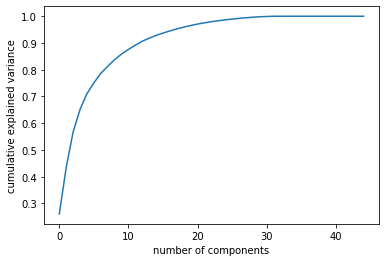

In [100]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)
pca_cumsum_plot(resnet50_pca)

Looking at the gaphs above, we can see that PCA can explain almost all the variance in as many dimensions as there are samples.

It is also interesting to note the difference in shape between the VGG graphs and the ResNet one. This is probably due to the fact that ResNet only had 2048 dimensions to start with, while VGGs had 25,088

In [101]:
# PCA transformations of covnet outputs
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

# Clustering
Let's write a couple of functions that would create and fit KMeans and Gaussian Mixture models. While it can make sense to combine them in one function that returns both, I've seperated them so we can execute them seperately and make some observations without overloading the PC

In [102]:
def create_train_kmeans(data, number_of_clusters=len(codes)):
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    
    k=KMeans(n_clusters=number_of_clusters)
    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [103]:
def create_train_gmm(data, number_of_clusters=len(codes)):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=728)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g

In [104]:
# Let's pass the data into the algorithm and predict who lies in which cluster. 
# Since we're using the same data that we trained it on, this should give us the training results.

# Here we create and fit a KMeans model with the PCA outputs
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)

print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)

print("\nResNet50")
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

KMeans (PCA): 

VGG16
Training took 0.0468747615814209 seconds

VGG19
Training took 0.04787254333496094 seconds

ResNet50
Training took 0.0438840389251709 seconds


In [105]:
K_vgg19_pca

KMeans(n_clusters=3)

In [106]:
# Same for Gaussian Model
print("GMM (PCA): \n")

print("VGG16")
G_vgg16_pca = create_train_gmm(vgg16_output_pca)

print("\nVGG19")
G_vgg19_pca = create_train_gmm(vgg19_output_pca)

print("\nResNet50")
G_resnet50_pca = create_train_gmm(resnet50_output_pca)

GMM (PCA): 

VGG16
Training took 0.010969877243041992 seconds

VGG19
Training took 0.0109710693359375 seconds

ResNet50
Training took 0.010970592498779297 seconds


In [107]:
# Let's also create models for the covnet outputs without PCA for comparison
print("KMeans: \n")

print("VGG16:")
K_vgg16 = create_train_kmeans(vgg16_output)

print("\nVGG19:")
K_vgg19 = create_train_kmeans(vgg19_output)

print("\nResNet50:")
K_resnet50 = create_train_kmeans(resnet50_output)

KMeans: 

VGG16:
Training took 0.35805320739746094 seconds

VGG19:
Training took 0.37300705909729004 seconds

ResNet50:
Training took 1.5189383029937744 seconds


# Predictions

In [108]:
# Now we get the custer model predictions

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16.predict(vgg16_output)
k_vgg19_pred = K_vgg19.predict(vgg19_output)
k_resnet50_pred = K_resnet50.predict(resnet50_output)

# Gaussian Mixture with PCA outputs
g_resnet50_pred_pca = G_resnet50_pca.predict(resnet50_output_pca)
g_vgg16_pred_pca = G_vgg16_pca.predict(vgg16_output_pca)
g_vgg19_pred_pca = G_vgg19_pca.predict(vgg19_output_pca)

In [109]:
vgg16_output_pca[0]

array([-5.5574260e+00,  3.5424869e+00,  3.5938985e+00,  7.5378513e+00,
       -4.1402345e+00, -1.3372842e+00,  2.1850009e-01, -8.9111179e-01,
       -8.3233666e-01, -1.7417972e+00, -3.8181853e-01,  9.5655370e-01,
        1.7235193e-01,  2.1309260e-01, -6.1233455e-01, -4.5452639e-02,
        7.7535069e-01, -3.8672838e-01, -9.2455781e-01, -4.5939547e-01,
        7.5327599e-01, -1.1914930e-01, -3.8509941e-01,  4.7069460e-01,
       -2.8329527e-01, -1.4868069e+00,  1.6706030e-01,  6.2818408e-02,
        3.4442808e-02, -4.8074305e-02, -2.4474222e-02, -1.6326733e-01,
        1.2273900e-05,  6.0070306e-07,  1.8626451e-09,  1.0430813e-07,
        3.3527613e-08, -1.4435500e-07,  2.4389010e-08,  9.4063580e-08,
        6.2398612e-08, -3.5390258e-08, -6.0535967e-08, -1.2293458e-07,
        5.9604645e-08], dtype=float32)

In [110]:
k_vgg19_pred

array([1, 2, 1, 2, 1, 2, 1, 0, 1, 1, 2, 0, 2, 2, 2, 2, 0, 2, 2, 1, 0, 2,
       2, 2, 1, 2, 2, 1, 1, 0, 1, 1, 0, 2, 1, 1, 2, 2, 0, 2, 2, 1, 1, 1,
       1])

Remember that the clustering algorith does not detect which images are cats and which are dogs, it only groups images that look alike together and assigns them a number arbitrarily.

We now need to count how many of each label are in each cluster, this way we can take a look and if sufficient eperation has happened we can quicly see which cluster is which label. So let's write a function that does that.

In [111]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [112]:
# Cluster counting for VGG16 Means
vgg16_cluster_count = cluster_label_count(k_vgg16_pred, y_train)
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, y_train)

# VGG19 KMeans
vgg19_cluster_count = cluster_label_count(k_vgg19_pred, y_train)
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, y_train)

# ResNet50 KMeans
resnet_cluster_count = cluster_label_count(k_resnet50_pred, y_train)
resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca, y_train)

# GMM
g_vgg16_cluster_count_pca = cluster_label_count(g_vgg16_pred_pca, y_train)
g_vgg19_cluster_count_pca = cluster_label_count(g_vgg19_pred_pca, y_train)
g_resnet50_cluster_count_pca = cluster_label_count(g_resnet50_pred_pca, y_train)

In [113]:
print("KMeans VGG16: ")
vgg16_cluster_count

KMeans VGG16: 


,0,1,2
V3,7,0,8
V2,3,9,1
V1,0,17,0


In [114]:
print("KMeans VGG16 (PCA): ")
vgg16_cluster_count_pca

KMeans VGG16 (PCA): 


,0,1,2
V3,14,0,1
V2,4,3,6
V1,0,12,5


In [115]:
print("GMM VGG16: ")
g_vgg16_cluster_count_pca

GMM VGG16: 


,0,1,2
V3,6,8,1
V2,0,4,9
V1,0,0,17


In [116]:
print("KMeans VGG19: ")
vgg19_cluster_count

KMeans VGG19: 


,0,1,2
V3,0,0,15
V2,2,6,5
V1,5,12,0


In [117]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_count_pca

KMeans VGG19 (PCA): 


,0,1,2
V3,0,0,15
V2,5,3,5
V1,4,13,0


In [118]:
print("GMM VGG19 (PCA): ")
g_vgg19_cluster_count_pca

GMM VGG19 (PCA): 


,0,1,2
V3,6,8,1
V2,0,4,9
V1,0,0,17


In [119]:
print("KMeans Resnet50: ")
resnet_cluster_count

KMeans Resnet50: 


,0,1,2
V3,3,1,11
V2,0,8,5
V1,0,17,0


In [120]:
print("Kmeans Resnet50 (PCA): ")
resnet_cluster_count_pca

Kmeans Resnet50 (PCA): 


,0,1,2
V3,11,1,3
V2,5,8,0
V1,0,17,0


In [121]:
print("GMM Resnet50 (PCA): ")
g_resnet50_cluster_count_pca

GMM Resnet50 (PCA): 


,0,1,2
V3,11,3,1
V2,5,0,8
V1,0,0,17


# Cluster - Label assignment
In this part, we will manually look at the cluster count and give a best guess as to which cluster corresponds to which label. While normally each cluster will mostly consist of one label, it is not necessary the case if the clustering algorithm fails to seperate the images. It is therefore better to take stock here, and make sure that we are on the right path.

In [318]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["V3", "V1", "V2"]
vgg16_cluster_code_pca = ["V3", "V1", "V2"]

vgg19_cluster_code = ["V3", "V2", "V1"]
vgg19_cluster_code_pca = ["V3", "V2", "V1"]
# g_vgg19_cluster_code_pca = ["D25", "D19", "C8", "C1"]

# Replace the predicted clusters with their labels

In [319]:
vgg16_pred_codes = [vgg16_cluster_code[x] for x in k_vgg16_pred]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in k_vgg19_pred]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]
# g_vgg19_pred_codes_pca = [g_vgg19_cluster_code_pca[x] for x in g_vgg19_pred_pca]

# Metrics

In [320]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16:", print_scores(y_train, vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(y_train, vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(y_train, vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(y_train, vgg19_pred_codes_pca))
# print("GMM VGG19 (PCA)", print_scores(y_train, g_vgg19_pred_codes_pca))

KMeans VGG16: 
	F1 Score: 0.48053559   |   Accuracy: 0.48053559
KMeans VGG16 (PCA) 
	F1 Score: 0.69282828   |   Accuracy: 0.69282828

KMeans VGG19:  
	F1 Score: 0.12903226   |   Accuracy: 0.12903226
KMeans VGG19 (PCA):  
	F1 Score: 0.06896552   |   Accuracy: 0.06896552


# Testing

In [125]:
# Let's put it all together

def all_covnet_transform(data):
    vgg16 = covnet_transform(vgg16_model, data)
    vgg19 = covnet_transform(vgg19_model, data)
    resnet50 = covnet_transform(resnet50_model, data)
    
    return vgg16, vgg19, resnet50


def image_load_to_cluster_count(codes):
    # Load images
    images, labels = load_images(codes)
    print(len(images), len(labels))
    show_random_images(images, labels)
    
    # Normalise images
    images, labels = normalise_images(images, labels)
    
    # Split data
    data, labels = shuffle_data(images, labels)
    
    # Get covnet outputs
    vgg16_output, vgg19_output, resnet50_output = all_covnet_transform(data)
    
    # Get PCA transformations
    vgg16_output_pca = create_fit_PCA(vgg16_output).transform(vgg16_output)
    vgg19_output_pca = create_fit_PCA(vgg19_output).transform(vgg19_output)
    resnet50_output_pca = create_fit_PCA(resnet50_output).transform(resnet50_output)
    
    # Cluster
    clusters = len(codes)
    
    K_vgg16_pred = create_train_kmeans(vgg16_output, clusters).predict(vgg16_output)
    K_vgg19_pred = create_train_kmeans(vgg19_output, clusters).predict(vgg19_output)
    K_resnet50_pred = create_train_kmeans(resnet50_output, clusters).predict(resnet50_output)
    K_vgg16_pred_pca = create_train_kmeans(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    K_vgg19_pred_pca = create_train_kmeans(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    K_resnet50_pred_pca = create_train_kmeans(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    G_vgg16_pred_pca = create_train_gmm(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    G_vgg19_pred_pca = create_train_gmm(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    G_resnet50_pred_pca = create_train_gmm(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    
    # Count
    vgg16_cluster_count = cluster_label_count(K_vgg16_pred, labels)
    vgg16_cluster_count_pca = cluster_label_count(K_vgg16_pred_pca, labels)

    # VGG19 KMeans
    vgg19_cluster_count = cluster_label_count(K_vgg19_pred, labels)
    vgg19_cluster_count_pca = cluster_label_count(K_vgg19_pred_pca, labels)

    # ResNet50 KMeans
    resnet_cluster_count = cluster_label_count(K_resnet50_pred, labels)
    resnet_cluster_count_pca = cluster_label_count(K_resnet50_pred_pca, labels)

    # GMM
    g_vgg16_cluster_count_pca = cluster_label_count(G_vgg16_pred_pca, labels)
    g_vgg19_cluster_count_pca = cluster_label_count(G_vgg19_pred_pca, labels)
    g_resnet50_cluster_count_pca = cluster_label_count(G_resnet50_pred_pca, labels)
    
    print("KMeans VGG16: ")
    print(vgg16_cluster_count)
    print("\nKMeans VGG16 (PCA): ")
    print(vgg16_cluster_count_pca)
    print("\nGMM VGG16: ")
    print(g_vgg16_cluster_count_pca)
    print("\nKMeans VGG19: ")
    print(vgg19_cluster_count)
    print("\nKMeans VGG19 (PCA): ")
    print(vgg19_cluster_count_pca)
    print("GMM VGG19 (PCA): ")
    print(g_vgg19_cluster_count_pca)
    print("KMeans Resnet50: ")
    print(resnet_cluster_count)
    print("Kmeans Resnet50 (PCA): ")
    print(resnet_cluster_count_pca)
    print("GMM Resnet50 (PCA): ")
    print(g_resnet50_cluster_count_pca)
    
    return  K_vgg16_pred, K_vgg16_pred_pca, K_vgg19_pred, K_vgg19_pred_pca, G_vgg19_pred_pca, images, labels

51 51
2 random images for code V3


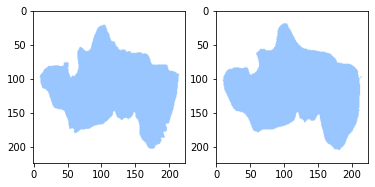

2 random images for code V2


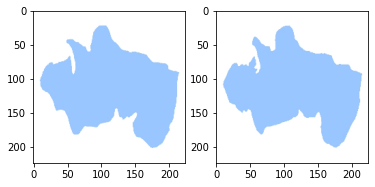

2 random images for code V1


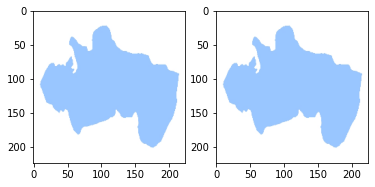

2/2 [==============================] - 2s 748ms/step
Training took 0.34607601165771484 seconds
Training took 0.38197851181030273 seconds
Training took 1.466078758239746 seconds
Training took 0.04886889457702637 seconds
Training took 0.04787278175354004 seconds
Training took 0.04886913299560547 seconds
Training took 0.010970592498779297 seconds
Training took 0.011967897415161133 seconds
Training took 0.011968135833740234 seconds
KMeans VGG16: 
     0   1  2
V3   0  15  0
V2   3   5  5
V1  13   0  4

KMeans VGG16 (PCA): 
     0  1  2
V3   0  7  8
V2   8  4  1
V1  17  0  0

GMM VGG16: 
    0  1   2
V3  6  8   1
V2  0  4   9
V1  0  0  17

KMeans VGG19: 
     0   1  2
V3  15   0  0
V2   4   8  1
V1   0  12  5

KMeans VGG19 (PCA): 
     0  1   2
V3  15  0   0
V2   5  5   3
V1   0  4  13
GMM VGG19 (PCA): 
    0  1   2
V3  6  8   1
V2  0  4   9
V1  0  0  17
KMeans Resnet50: 
    0   1   2
V3  3   1  11
V2  0   8   5
V1  0  17   0
Kmeans Resnet50 (PCA): 
     0   1  2
V3  11   1  3
V2   5   8  

In [126]:
codes = ["V1", "V2", "V3"]
outputs = image_load_to_cluster_count(codes)

In [317]:
vgg16_cluster_code = ["V3", "V1", "V2"]
vgg16_cluster_code_pca = ["V3", "V1", "V2"]

vgg19_cluster_code = ["V3", "V2", "V1"]
vgg19_cluster_code_pca = ["V3", "V2", "V1"]



vgg16_pred_codes = [vgg16_cluster_code[x] for x in outputs[0]]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in outputs[1]]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in outputs[2]]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in outputs[3]]
g_vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in outputs[4]]

print("KMeans VGG16:", print_scores(outputs[-1], vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(outputs[-1], vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(outputs[-1], vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(outputs[-1], vgg19_pred_codes_pca))
print("GMM VGG19 (PCA)", print_scores(outputs[-1], g_vgg19_pred_codes_pca))

KMeans VGG16: 
	F1 Score: 0.15151515   |   Accuracy: 0.15151515
KMeans VGG16 (PCA) 
	F1 Score: 0.03030303   |   Accuracy: 0.03030303

KMeans VGG19:  
	F1 Score: 0.60066134   |   Accuracy: 0.60066134
KMeans VGG19 (PCA):  
	F1 Score: 0.69985570   |   Accuracy: 0.69985570
GMM VGG19 (PCA) 
	F1 Score: 0.55471861   |   Accuracy: 0.55471861


In [128]:
df0=pd.read_csv('Ichkel-Tunisia.csv')

C:\Users\alaba\AppData\Local\Temp\ipykernel_21532\837600920.py:1: DtypeWarning: Columns (1,2,8,9,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df0=pd.read_csv('Ichkel-Tunisia.csv')


In [129]:
df0.columns

Index(['TimeStamp', 'MeanWindSpeedUID_10,0m|Mean wind speed|L-1,00|U75,00',
       'DirectionUID_10,0m|Wind direction|L0,00|U360,00', 'Comment_10,0m',
       'TimeStampStatus_10,0m', 'SampleStatus_10,0m',
       'DataStatus_MeanWindSpeedUID_10,0m', 'DataStatus_DirectionUID_10,0m',
       'MeanWindSpeedUID_100,0m|Mean wind speed|L-1,00|U75,00',
       'DirectionUID_100,0m|Wind direction|L0,00|U360,00', 'Comment_100,0m',
       'TimeStampStatus_100,0m', 'SampleStatus_100,0m',
       'DataStatus_MeanWindSpeedUID_100,0m', 'DataStatus_DirectionUID_100,0m',
       'TemperatureUID_2,0m|Temperature|L-50,00|U60,00',
       'SolarRadiationUID_2,0m|Solar irradiation|L-10,00|U2000,00',
       'StabilityUID_2,0m|Stability (1/L)',
       'RelativeHumidityUID_2,0m|Relative humidity|L0,00|U100,00',
       'Comment_2,0m', 'TimeStampStatus_2,0m', 'SampleStatus_2,0m',
       'DataStatus_TemperatureUID_2,0m', 'DataStatus_SolarRadiationUID_2,0m',
       'DataStatus_StabilityUID_2,0m', 'DataStatus_RelativeH

In [130]:
df0.shape

(298057, 26)

In [131]:
df=df0[["TimeStamp","MeanWindSpeedUID_10,0m|Mean wind speed|L-1,00|U75,00","DirectionUID_10,0m|Wind direction|L0,00|U360,00"
      ,"MeanWindSpeedUID_100,0m|Mean wind speed|L-1,00|U75,00","DirectionUID_100,0m|Wind direction|L0,00|U360,00",
      "TemperatureUID_2,0m|Temperature|L-50,00|U60,00","SolarRadiationUID_2,0m|Solar irradiation|L-10,00|U2000,00",
      "StabilityUID_2,0m|Stability (1/L)","RelativeHumidityUID_2,0m|Relative humidity|L0,00|U100,00"]]
df=df.drop(df.index[0])
df.rename(columns={"MeanWindSpeedUID_10,0m|Mean wind speed|L-1,00|U75,00": "MWS@10m", 
                   "DirectionUID_10,0m|Wind direction|L0,00|U360,00": "WD@10m",
                  "MeanWindSpeedUID_100,0m|Mean wind speed|L-1,00|U75,00":"MWS@100m",
                  "DirectionUID_100,0m|Wind direction|L0,00|U360,00":"WD@100m",
                  "TemperatureUID_2,0m|Temperature|L-50,00|U60,00":"Temperature",
                  "SolarRadiationUID_2,0m|Solar irradiation|L-10,00|U2000,00":"SolarRadiation",
                  "StabilityUID_2,0m|Stability (1/L)":"Stability",
                  "RelativeHumidityUID_2,0m|Relative humidity|L0,00|U100,00":"Humidity"},inplace=True)
df.head()

,TimeStamp,MWS@10m,WD@10m,MWS@100m,WD@100m,Temperature,SolarRadiation,Stability,Humidity
1,1/1/1988 1:00,1.65,190.9,2.8,195.2,8.9,0,0.381427,90.4
2,1/1/1988 2:00,1.36,206.3,2.8,216.6,9.1,0,0.705773,92.9
3,1/1/1988 3:00,1.75,238.3,3.85,256.8,8.3,0,1.81518,95.4
4,1/1/1988 4:00,2.23,263.3,5.1,282.2,7.5,0,2.29405,92.9
5,1/1/1988 5:00,2.2,274.2,5.17,292.2,7.4,0,1.405246,92.7


In [132]:
df['Temperature']=df['Temperature'].astype('float64')
df['Stability']=pd.to_numeric(df['Stability'],errors='coerce')
df['SolarRadiation']=df['SolarRadiation'].astype('float64')
df['Humidity']=df['Humidity'].astype('float64')
df['MWS@10m']=df['MWS@10m'].astype('float64')
df['WD@10m']=df['WD@10m'].astype('float64')
df['MWS@100m']=df['MWS@100m'].astype('float64')
df['WD@100m']=df['WD@100m'].astype('float64')


In [133]:
df.describe()

,MWS@10m,WD@10m,MWS@100m,WD@100m,Temperature,SolarRadiation,Stability,Humidity
count,298056.000000,298056.000000,298056.000000,298056.000000,298056.000000,298056.000000,2.980430e+05,298056.000000
mean,3.797436,215.934120,6.046575,217.518100,19.039903,202.964716,2.817561e+01,75.070367
std,2.049724,94.748877,3.072152,95.751418,6.140357,278.970131,1.145400e+04,14.493030
min,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,-7.781561e+04,12.500000
25%,2.160000,133.400000,3.770000,133.800000,14.100000,0.000000,-1.630500e-02,65.100000
50%,3.480000,257.800000,5.720000,264.500000,18.500000,10.240000,6.752000e-03,77.600000
75%,5.020000,294.300000,7.940000,295.800000,23.700000,374.295000,3.865000e-02,86.800000
max,14.630000,359.900000,21.770000,359.900000,45.500000,987.960000,5.448252e+06,100.000000


In [134]:
corr=df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,MWS@10m,WD@10m,MWS@100m,WD@100m,Temperature,SolarRadiation,Stability,Humidity
MWS@10m,1.000000,0.271168,0.957930,0.266631,-0.077316,0.123942,-0.003255,-0.269279
WD@10m,0.271168,1.000000,0.262210,0.931684,-0.175312,-0.055406,-0.000885,0.027929
MWS@100m,0.957930,0.262210,1.000000,0.260870,-0.152442,-0.071088,-0.003049,-0.177225
WD@100m,0.266631,0.931684,0.260870,1.000000,-0.155600,-0.044447,-0.001102,0.007365
Temperature,-0.077316,-0.175312,-0.152442,-0.155600,1.000000,0.445701,-0.001589,-0.532397
SolarRadiation,0.123942,-0.055406,-0.071088,-0.044447,0.445701,1.000000,-0.001942,-0.603485
Stability,-0.003255,-0.000885,-0.003049,-0.001102,-0.001589,-0.001942,1.000000,0.002451
Humidity,-0.269279,0.027929,-0.177225,0.007365,-0.532397,-0.603485,0.002451,1.000000


In [135]:
df['MWS@10m'].corr(df['MWS@10m'])

1.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


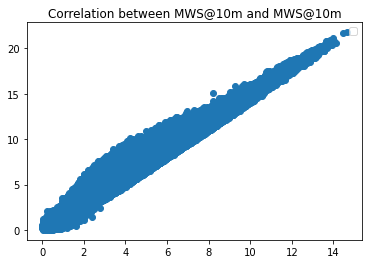

In [136]:
plt.scatter(df['MWS@10m'],df['MWS@100m'])
plt.title("Correlation between MWS@10m and MWS@10m")
plt.legend()
plt.show()

In [137]:
df['WD@100m'].corr(df['WD@10m'])

0.9316837391776707

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


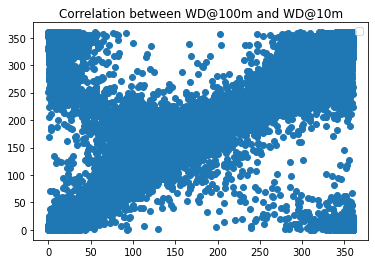

In [138]:
plt.scatter(df['WD@100m'],df['WD@10m'])
plt.title("Correlation between WD@100m and WD@10m")
plt.legend()
plt.show()

In [139]:
df.drop(columns=['MWS@10m'],inplace=True)
df.drop(columns=['WD@10m'],inplace=True)
df.head()

,TimeStamp,MWS@100m,WD@100m,Temperature,SolarRadiation,Stability,Humidity
1,1/1/1988 1:00,2.80,195.2,8.9,0.0,0.381427,90.4
2,1/1/1988 2:00,2.80,216.6,9.1,0.0,0.705773,92.9
3,1/1/1988 3:00,3.85,256.8,8.3,0.0,1.815180,95.4
4,1/1/1988 4:00,5.10,282.2,7.5,0.0,2.294050,92.9
5,1/1/1988 5:00,5.17,292.2,7.4,0.0,1.405246,92.7


In [140]:
df[df['TimeStamp']=='3/7/2021 4:00']

,TimeStamp,MWS@100m,WD@100m,Temperature,SolarRadiation,Stability,Humidity
290860,3/7/2021 4:00,5.84,160.8,12.0,0.0,0.082669,85.9


In [141]:
max(df['Temperature'])

45.5

In [142]:
df['SolarRadiation'].value_counts()[0]

136970

In [143]:
#df.drop(columns=['TimeStamp'],inplace=True)
df.head()

,TimeStamp,MWS@100m,WD@100m,Temperature,SolarRadiation,Stability,Humidity
1,1/1/1988 1:00,2.80,195.2,8.9,0.0,0.381427,90.4
2,1/1/1988 2:00,2.80,216.6,9.1,0.0,0.705773,92.9
3,1/1/1988 3:00,3.85,256.8,8.3,0.0,1.815180,95.4
4,1/1/1988 4:00,5.10,282.2,7.5,0.0,2.294050,92.9
5,1/1/1988 5:00,5.17,292.2,7.4,0.0,1.405246,92.7


In [188]:
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"])

In [191]:
new_df = df.copy()
new_df = df.groupby([df['TimeStamp'].dt.year, df['TimeStamp'].dt.month])\
                    [df.columns.difference(["TimeStamp"])].agg('mean').round(2)

test = new_df.reset_index(level = 1).rename({"TimeStamp":"Month"}, axis = 1)\
            .reset_index().rename({"TimeStamp":"Year"}, axis = 1)

test["Date"] = test["Month"].astype("str") +"/"+ test["Year"].astype("str")
test.drop(["Year", "Month"], axis = 1, inplace = True)

columns = list(test.columns)
l = []
l.append(columns.pop())
new_columns = l + columns

test = test[new_columns]
test.head()

,Date,Humidity,MWS@100m,SolarRadiation,Stability,Temperature,WD@100m
0,1/1988,77.44,7.30,104.46,1.95,13.23,243.04
1,2/1988,76.29,7.34,141.27,-0.09,12.08,237.59
2,3/1988,71.50,8.85,205.01,0.04,13.60,268.69
3,4/1988,76.67,6.22,246.89,0.07,15.86,201.84
4,5/1988,73.11,5.44,268.97,0.66,20.19,203.87


In [144]:
x = df[['Temperature','Humidity']] # 1t for rows and second for columns

In [145]:
x.dropna(inplace=True)
kmeans = KMeans(3)
kmeans.fit(x)

C:\Users\alaba\AppData\Local\Temp\ipykernel_21532\3535246779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.dropna(inplace=True)


KMeans(n_clusters=3)

In [146]:
identified_clusters = kmeans.fit_predict(x)
list(identified_clusters).count(2)

104620

In [201]:
kmeans.fit_predict([[2.80,195.2,14,81],[2.80,195.2,1,50],[2.80,195.2,17,77]])

array([2, 0, 1])

## Indentifying to wich Image Cluster corresponds the Panel Data

In [167]:
def load_image(code="V1",DIR="./lake_img",folder_name="V1-high",file="high_11_2014.jpg"):
  file_path = os.path.join(str(DIR),str(folder_name),str(file))
             # Read the image
  image = cv2.imread(file_path)

            # Resize it to 224 x 224 
  image = cv2.resize(image, (224,224))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  images=[image]
  codes=[code]  
  images,labs=normalise_images(images,codes)
  return images,labs

In [276]:
def full_pred_function(image,label):
  vgg16_output_1 = covnet_transform(vgg16_model, image)
  

  vgg19_output_1 = covnet_transform(vgg19_model, image)
  

  resnet50_output_1 = covnet_transform(resnet50_model,image)

  k_vgg16_pred = K_vgg16.predict(vgg16_output_1)
  k_vgg19_pred = K_vgg19.predict(vgg19_output_1)
  k_resnet50_pred = K_resnet50.predict(resnet50_output_1)
  return( k_vgg16_pred,k_vgg19_pred,k_resnet50_pred)

In [278]:
image,lab=load_image(code="V1",DIR="./lake_img",folder_name="V1-high",file="high_6_2010.jpg")
full_pred_function(image,lab)

1/1 [==============================] - 0s 175ms/step


(array([1]), array([1]), array([1]))

The date 9/2001 corresponds to the VGG 19  image cluster number 2 .

The date 6/2010 corresponds to the VGG 19  image cluster number 1 .

The date 11/2014 corresponds to the VGG 19 image cluster number 0 .

In [202]:
test[test['Date']=='6/2010']

,Date,Humidity,MWS@100m,SolarRadiation,Stability,Temperature,WD@100m
269,6/2010,70.31,6.17,306.66,0.2,22.76,224.23


We take the above row as the characterization vector of the image cluster 1 .

In [199]:
test[test['Date']=='11/2014']


,Date,Humidity,MWS@100m,SolarRadiation,Stability,Temperature,WD@100m
322,11/2014,74.03,5.86,109.76,0.02,18.78,197.45


In [200]:
test[test['Date']=='9/2001']

,Date,Humidity,MWS@100m,SolarRadiation,Stability,Temperature,WD@100m
164,9/2001,72.3,5.35,220.96,0.71,23.83,234.96


In [223]:
kmeans.fit_predict([[6.17,224.23,22.76,70.31],[5.86,197.45,18.78,74.03],[5.35,234.96,22.83,72.3]])

array([0, 1, 2])

Now we identify that the data cluster number 0 corresponds to the image cluster number 1 ,the data cluster number 1 corresponds to the image cluster number 0, and the data cluster number 2 corresponds to the image cluster number 2

In [238]:
def final_prediction(L): # L has to be a list of > 3 lists with each having 4 values
    figure, axis = plt.subplots(1, len(L))
    k_pred=kmeans.fit_predict(L)
    image_0,lab_0=load_image(code="V1",DIR="./lake_img",folder_name="V1-high",file="high_11_2014.jpg")
    image_1,lab_1=load_image(code="V1",DIR="./lake_img",folder_name="V1-high",file="high_6_2010.jpg")
    image_2,lab_2=load_image(code="V2",DIR="./lake_img",folder_name="V2-meduim",file="meduim_9_2001.jpg")
    for i in range(len(L)):
        if(k_pred[i]==1):
            axis[i].imshow(image_0[0])
        elif(k_pred[i]==0):
            axis[i].imshow(image_1[0])
        else :
            axis[i].imshow(image_2[0])
    plt.show()
    


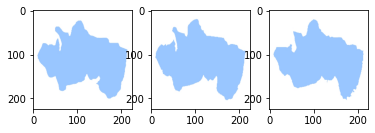

In [239]:
final_prediction([[6.17,224.23,22.76,70.31],[5.86,197.45,18.78,74.03],[5.35,234.96,22.83,72.3]])

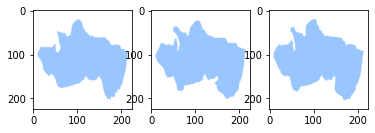

In [241]:

final_prediction([[6.17,224.23,22.76,70.31],[3.85,256.8,8.3,95.4],[5.35,234.96,22.83,72.3]])

In [242]:
kmeans.fit_predict([[6.17,224.23,22.76,70.31],[3.85,256.8,8.3,95.4],[5.35,234.96,22.83,72.3]])

array([0, 1, 2])

In [266]:
test_df=test[(test['Date']=='2/2014')|(test['Date']=='2/2019')|(test['Date']=='8/2005')|(test['Date']=='11/2016')
                    |(test['Date']=='12/1990')|(test['Date']=='12/1993')|(test['Date']=='12/1995')
                    |(test['Date']=='12/1998')|(test['Date']=='12/2000')|(test['Date']=='12/2006')
                    |(test['Date']=='12/2008')|(test['Date']=='12/2011')]

In [312]:
test_df

,Date,Humidity,MWS@100m,SolarRadiation,Stability,Temperature,WD@100m
0,12/1990,80.33,6.95,84.36,0.16,11.67,233.71
1,12/1993,77.81,6.86,85.15,0.08,13.79,266.64
2,12/1995,79.47,6.35,86.69,-0.13,14.99,216.03
3,12/1998,76.69,6.63,95.78,0.08,12.58,228.16
4,12/2000,79.44,6.70,91.28,0.11,14.40,231.14
5,8/2005,70.97,5.72,266.08,0.19,25.88,235.53
6,12/2006,84.29,4.61,87.66,0.11,14.55,195.44
7,12/2008,79.79,6.21,89.27,0.70,12.95,235.06
8,12/2011,80.54,7.37,86.93,0.08,14.31,253.36
9,2/2014,76.67,7.27,143.74,-1.38,13.89,247.28


In [301]:
kmeans.fit_predict(test_df[["MWS@100m","WD@100m","Temperature","Humidity"]])

array([2, 0, 2, 2, 2, 2, 1, 2, 0, 0, 1, 2])

In [311]:
images,label=load_image(code="test",DIR="./lake_img",folder_name="test",file="12_2000.jpg")
int(full_pred_function(images,labels)[1])

1/1 [==============================] - 0s 178ms/step


2

In [316]:

    error=0
    k_pred=kmeans.fit_predict(test_df[["MWS@100m","WD@100m","Temperature","Humidity"]])
    file_names = [file for file in os.listdir("./lake_img/test")]
    i=0
    for file in file_names:
        
        images,label=load_image(code="test",DIR="./lake_img",folder_name="test",file=file)
        im_pred=int(full_pred_function(images,labels)[1])
        if k_pred[i]!=im_pred :
            error+=1
        i+=1
    error=error/i
    print("La probabilité que le cluster choisit ne correspond pas est de :",error)
    
    

1/1 [==============================] - 0s 177ms/step
La probabilité que le cluster choisit ne correspond pas est de : 0.5
